In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

# A comment

from __future__ import (print_function, division, absolute_import)

import os
import glob
import copy
import sys
import warnings

import numpy as np

# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

from astropy.table import \
    Table, \
    Column, \
    vstack, \
    unique
    
from astropy.utils.metadata import MergeConflictWarning
warnings.filterwarnings('ignore', category=MergeConflictWarning, 
                        append=True)
from astropy import units as u
from astropy.coordinates import SkyCoord as sc
from astropy.utils.console import ProgressBar
from astropy import visualization as vs

import statistics as stat

plt.rcParams['figure.figsize'] = (12, 7)

In [2]:
table_hsc = Table.read('hsc_s16a_fastlane_g09_short.fits', format = 'fits')
table_decals = Table.read ('decals_dr3_g09_short.fits', format = 'fits')

table_hsc.sort('rcmodel_mag')
table_decals.sort('rmag_decal')

ra_hsc = table_hsc['ra']
dec_hsc = table_hsc['dec']
ra_decals = table_decals['RA']
dec_decals = table_decals['DEC']


In [3]:
hsc = sc(ra=ra_hsc*u.degree, dec=dec_hsc*u.degree)  
decals = sc(ra=ra_decals*u.degree, dec=dec_decals*u.degree)  
idx, d2d, d3d = hsc.match_to_catalog_sky(decals)

Now idx are indices into decals catalog that are the closest objects to each of the coordinates in hsc catalog, d2d are the on-sky distances between them, and d3d are the 3-dimensional distances. 

now we get arrays of the luminosities and plot them

In [4]:
#split hsc into four redshift bins
hsc_z = table_hsc['z_best']
#.25-.325, .325-.4, .4-.475, .475-.55
idx_1 = [x for x in range(len(hsc_z)) if (hsc_z[x] < .325)]
idx_2 = [x for x in range(len(hsc_z)) if (hsc_z[x] > .325) & (hsc_z[x]<.4)]
idx_3 = [x for x in range(len(hsc_z)) if (hsc_z[x] > .4) & (hsc_z[x]<.475)]
idx_4 = [x for x in range(len(hsc_z)) if hsc_z[x] > .475]

In [5]:
hsc_r_mag = table_hsc['rcmodel_mag'] - table_hsc['a_r']
hsc_r_mag_1 = hsc_r_mag[idx_1]
hsc_r_mag_2 = hsc_r_mag[idx_2]
hsc_r_mag_3 = hsc_r_mag[idx_3]
hsc_r_mag_4 = hsc_r_mag[idx_4]

hsc_g_mag = table_hsc['gcmodel_mag'] - table_hsc['a_g']
hsc_g_mag_1 = hsc_g_mag[idx_1]
hsc_g_mag_2 = hsc_g_mag[idx_2]
hsc_g_mag_3 = hsc_g_mag[idx_3]
hsc_g_mag_4 = hsc_g_mag[idx_4]

hsc_z_mag = table_hsc['zcmodel_mag'] - table_hsc['a_z'] 
hsc_z_mag_1 = hsc_z_mag[idx_1]
hsc_z_mag_2 = hsc_z_mag[idx_2]
hsc_z_mag_3 = hsc_z_mag[idx_3]
hsc_z_mag_4 = hsc_z_mag[idx_4]

In [6]:
decals_r_mag = table_decals['rmag_decal'][idx] - table_decals['a_g_decal'][idx]
decals_r_mag_1 = decals_r_mag[idx_1]
decals_r_mag_2 = decals_r_mag[idx_2]
decals_r_mag_3 = decals_r_mag[idx_3]
decals_r_mag_4 = decals_r_mag[idx_4]

decals_g_mag = table_decals['gmag_decal'][idx] - table_decals['a_r_decal'][idx]
decals_g_mag_1 = decals_g_mag[idx_1]
decals_g_mag_2 = decals_g_mag[idx_2]
decals_g_mag_3 = decals_g_mag[idx_3]
decals_g_mag_4 = decals_g_mag[idx_4]

decals_z_mag = table_decals['zmag_decal'][idx] - table_decals['a_z_decal'][idx]
decals_z_mag_1 = decals_z_mag[idx_1]
decals_z_mag_2 = decals_z_mag[idx_2]
decals_z_mag_3 = decals_z_mag[idx_3]
decals_z_mag_4 = decals_z_mag[idx_4]

In [7]:
rmag_diff = hsc_r_mag - decals_r_mag
rmag_diff_1 = hsc_r_mag_1 - decals_r_mag_1
rmag_diff_2 = hsc_r_mag_2 - decals_r_mag_2
rmag_diff_3 = hsc_r_mag_3 - decals_r_mag_3
rmag_diff_4 = hsc_r_mag_4 - decals_r_mag_4

In [8]:
plt.rc('text', usetex=False)

In [15]:
#84th, 16th, and 50th percentile, repectively

rmag_diff_new = rmag_diff[np.isfinite(rmag_diff)]
#rmag_diff_new = Y[np.isfinite(X) & np.isfinite(Y)]

eighty_four = np.percentile(rmag_diff_new, 16)
sixteen = np.percentile(rmag_diff_new, 84)
fifty = np.percentile(rmag_diff_new, 50)

data = [x for x in rmag_diff_new]
np.argsort(data)

#find the list of points in the specified percentiles
e = [x for x in data if (x<eighty_four) ]
s = [x for x in data if (x<sixteen)]
f = [x for x in data if (x<fifty) ]


/Users/danecross/anaconda/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


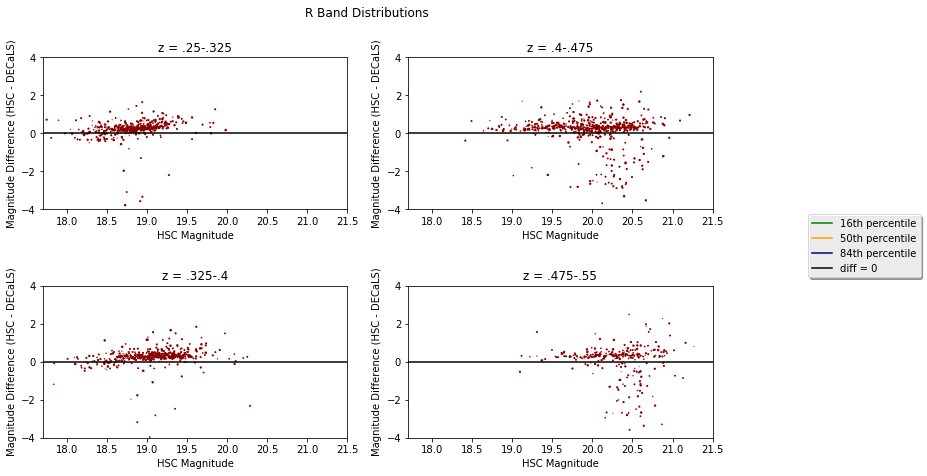

In [25]:
fig, axarr = plt.subplots(2, 2)

#data points
axarr[0,0].scatter(hsc_r_mag_1, rmag_diff_1, color = 'darkred',label='_nolegend_')
axarr[1,0].scatter(hsc_r_mag_2, rmag_diff_2, color = 'darkred',label='_nolegend_')
axarr[0,1].scatter(hsc_r_mag_3, rmag_diff_3, color = 'darkred',label='_nolegend_')
axarr[1,1].scatter(hsc_r_mag_4, rmag_diff_4, color = 'darkred',label='_nolegend_')

#.25-.325, .325-.4, .4-.475, .475-.55
axarr[0,0].set_title('z = .25-.325')
axarr[1,0].set_title('z = .325-.4')
axarr[0,1].set_title('z = .4-.475')
axarr[1,1].set_title('z = .475-.55')

fig.subplots_adjust(hspace=.5)

for (m,n), subplot in np.ndenumerate(axarr):
    #set the x and y axes to have the same dimensions and titles
    subplot.set_xlim(17.7,21.5)
    subplot.set_ylim(-4,4)
    subplot.set_xlabel('HSC Magnitude')
    subplot.set_ylabel('Magnitude Difference (HSC - DECaLS)')
    #percentile cutoffs
    subplot.plot( [eighty_four, eighty_four],[-5, 5], color = 'green', label = '16th percentile')
    subplot.plot([fifty, fifty], [-5, 5], color = 'orange', label = '50th percentile')
    subplot.plot( [sixteen,sixteen], [-5, 5], color = 'darkblue', label = '84th percentile')
    #y axis
    subplot.plot([17, 22], [0,0], color = 'black', label = 'diff = 0')

#legend
axarr[1,1].legend(loc='upper right', bbox_to_anchor=(1.7, 1.5),fancybox=True, shadow=True, ncol=1)

plt.suptitle('R Band Distributions')


In [11]:
eighty_five = np.percentile(hsc_g_mag, 85)
sixteen = np.percentile(hsc_g_mag, 16)
fifty = np.percentile(hsc_g_mag, 50)

gmag_diff = hsc_g_mag - decals_g_mag

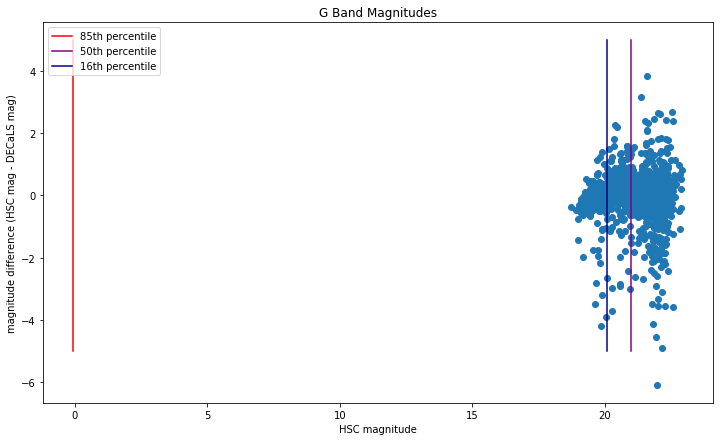

In [12]:
plt.scatter(hsc_g_mag, gmag_diff,label='_nolegend_')
plt.plot( [eighty_four, eighty_four],[-5, 5], color = 'red', label = '85th percentile')
plt.plot([fifty, fifty], [-5, 5], color = 'purple', label = '50th percentile')
plt.plot( [sixteen,sixteen], [-5, 5], color = 'darkblue', label = '16th percentile')
plt.ylabel("magnitude difference (HSC mag - DECaLS mag)")
plt.xlabel("HSC magnitude")
plt.title("G Band Magnitudes")
plt.legend(loc='upper left')

In [13]:
eighty_five = np.percentile(hsc_z_mag, 85)
sixteen = np.percentile(hsc_z_mag, 16)
fifty = np.percentile(hsc_z_mag, 50)

zmag_diff = hsc_z_mag - decals_z_mag

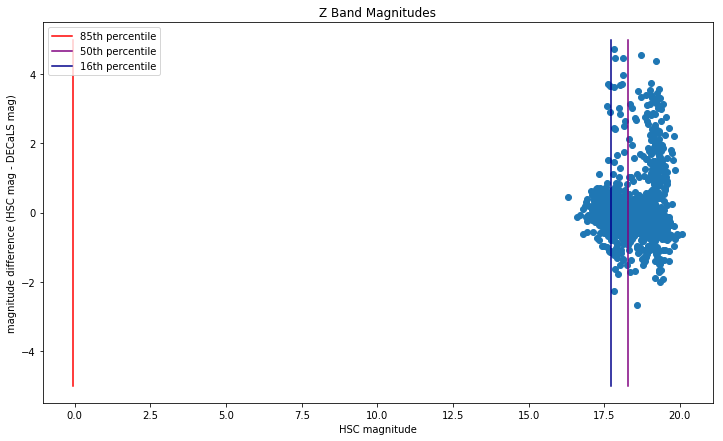

In [14]:
plt.scatter(hsc_z_mag, decals_z_mag-hsc_z_mag,label='_nolegend_' )
plt.plot( [eighty_four, eighty_four],[-5, 5], color = 'red', label = '85th percentile')
plt.plot([fifty, fifty], [-5, 5], color = 'purple', label = '50th percentile')
plt.plot( [sixteen,sixteen], [-5, 5], color = 'darkblue', label = '16th percentile')
plt.ylabel("magnitude difference (HSC mag - DECaLS mag)")
plt.xlabel("HSC magnitude")
plt.title("Z Band Magnitudes")
plt.legend(loc = 'upper left')